Рассмотрим нелинейное уравнение диффузии и применим к нему метод Ньютона

$
\Delta u + u^3 - \lambda u = 0
$


Рассмотрим следующую разностную схему для исходного дифференциального уравнения

$
\frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} + u_i^3 - \lambda u_i = 0
$


Тогда представить матрицу дискретного разностностного оператора можно в следующем виде:

$
J_{ij} =
\begin{cases} 
\frac{1}{\Delta x^2}, & j = i-1 \\
-\frac{2}{\Delta x^2} + 3u_i^2 - \lambda, & j = i \\
\frac{1}{\Delta x^2}, & j = i+1 \\
0, & \text{otherwise}.
\end{cases}
$


In [1]:
#Импортируем нужные библиотеки 

import os
import sys
import random
import warnings
import datetime


import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import get_cmap

import mplcyberpunk
plt.style.use('cyberpunk')

warnings.filterwarnings('ignore')

In [2]:
class NewtonDiffusion(object):

    def __init__(self, 
                 lambda_ : float = 0.8,
                 L : float = 1.0, 
                 Np : int = 2000, 
                 newton_eps : float = 1e-6,
                 maxiter : int = 20,
                 u_L : float = 1.0,
                 u_R : float =  1.0):

        """
        Класс для реализации метода Ньютона
        Атрибуты инициализации:
            - lambda_ - физический параметр исходного уравнения
            - L - длина отрезка
            - Np - размер сетки
            - newton_eps - ограничение на норму невязки
            - maxiter - максимальное количество итераций
            - u_L, u_R - граничные условия
        """

        self.lambda_ = lambda_
        self.L = L
        self.Np = Np
        self.newton_eps = newton_eps
        self.maxiter = maxiter
        self.u_L = u_L
        self.u_R = u_R

        self.dx = self.L/(self.Np - 1) # Шаг по сетке

    def compute_u(self,
                  verbose : bool = None):

        """
        Функция для вычисления дискретизации u по сетке
            - verbose - параметр для визуализации
        """
    
        self.u = np.linspace(0, 1, self.Np)           # В качестве начального приближения положим линейную функцию
        
        self.conv_hist = []                     # Массив с историей невязок
        self.u_hist = [self.u]                   # Массив с решениями

        for i in range(self.maxiter):
            J  = np.eye(self.Np)*(-2)
        
            # Заполним побочные диагонали оператора J
            J += np.diag(np.ones(self.Np-1), k = -1)     
            J += np.diag(np.ones(self.Np-1), k =  1)
        
            J /= self.dx**2
        
            J += np.diag(3*self.u**2, k = 0)
            J -= np.diag(np.ones(self.Np)*self.lambda_, k = 0)
        
            # Граничные условия
            J[0,  :] = 0.0
            J[-1, :] = 0.0
            J[0,  0] = 1.0
            J[-1,-1] = 1.0
        
            # Вычисление невязки
            d2u_dx2     = (np.roll(self.u, -1) - 2 * self.u + np.roll(self.u, 1)) / self.dx**2
            d2u_dx2[0]  = 0.0 
            d2u_dx2[-1] = 0.0
            resid       = d2u_dx2 + self.u**3 - self.lambda_ * self.u
        
            resid[0]    = self.u[0]  - self.u_L
            resid[-1]   = self.u[-1] - self.u_R

            # Проверка выполнения условия сходимости
            res_norm = np.linalg.norm(resid, ord=2)
            print(f'{str(datetime.datetime.now())[:-7]}  |  Iter {i}  |  Residual norm: {res_norm:.4e}')
            self.conv_hist.append(res_norm)
            if (res_norm <= self.newton_eps):
                print('-'*80)
                print(f'Converged')
                break
        
            # Переход на следующую итерацию
            delta_u = np.linalg.solve(J, -resid)
        
            self.u = self.u + delta_u 
        
            self.u_hist.append(self.u.copy())

        if verbose:
            plt.figure(figsize = (8,4))
            plt.plot(np.linspace(0.0, self.L, self.Np), self.u, lw = 2.5, color = 'blue', alpha = 0.4)
            plt.grid(color = 'black', alpha = 0.15)
            plt.xlabel('x', fontsize = 9)
            plt.ylabel('u(x)', fontsize = 9)
            plt.legend(['u(x)'], fontsize = 10)
            plt.show()

            plt.figure(figsize = (8,4))
            plt.plot(np.arange(1, len(self.u_hist)+1), np.log(self.conv_hist), lw = 2.5, color = 'magenta', alpha = 0.4, marker = 'o')
            plt.grid(color = 'black', alpha = 0.15)
            plt.xlabel('Iteration ID', fontsize = 9)
            plt.ylabel('log10(Residual)', fontsize = 9)
            plt.legend(['F(u(x)): Residual history'], fontsize = 10)
            plt.show()

2024-12-15 17:58:09  |  Iter 0  |  Residual norm: 8.5630e+00
2024-12-15 17:58:09  |  Iter 1  |  Residual norm: 2.4619e+01
2024-12-15 17:58:09  |  Iter 2  |  Residual norm: 4.0625e-01
2024-12-15 17:58:10  |  Iter 3  |  Residual norm: 2.3439e-04
2024-12-15 17:58:10  |  Iter 4  |  Residual norm: 2.8023e-08
--------------------------------------------------------------------------------
Converged


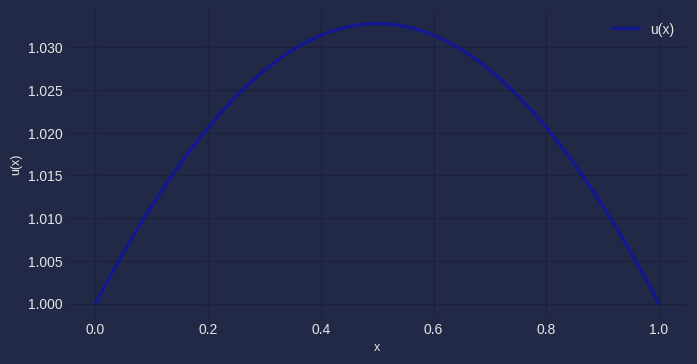

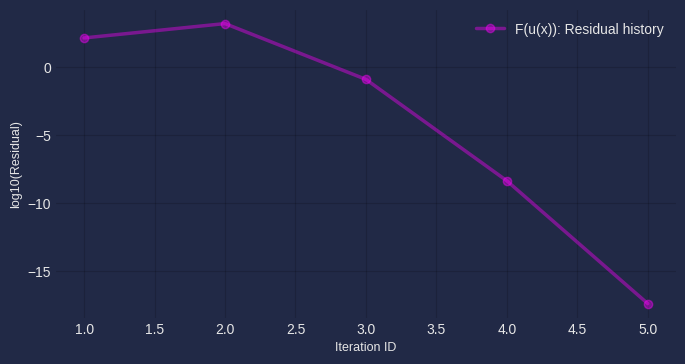

In [3]:
NewtonDiffusion_instance = NewtonDiffusion()
NewtonDiffusion_instance.compute_u(True)